In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore')
import io

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../Data/final_table.csv')
df = df.drop(columns= ['Unnamed: 0','flightdate'])

In [3]:
df['airline'].unique()

array(['Endeavor Air Inc.', 'Southwest Airlines Co.',
       'Mesa Airlines Inc.', 'Republic Airline', 'PSA Airlines Inc.',
       'United Air Lines Inc.', 'Delta Air Lines Inc.',
       'SkyWest Airlines Inc.', 'American Airlines Inc.',
       'Spirit Air Lines', 'Alaska Airlines Inc.', 'JetBlue Airways',
       'Allegiant Air', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Envoy Air', 'ExpressJet Airlines LLC',
       'Virgin America'], dtype=object)

In [4]:
ranking = df[['airline']]
dictionary = {
    'Allegiant Air':1,
    'Envoy Air':1,
    'PSA Airlines Inc.': 1,
    'Alaska Airlines Inc.': 1,
    'Spirit Air Lines': 1,
    'American Airlines Inc.': 2,
    'Mesa Airlines Inc.': 2,
    'Frontier Airlines Inc.': 2, 
    'Republic Airline': 2,
    'Virgin America': 2,
    'United Air Lines Inc.' : 3, 
    'Hawaiian Airlines Inc.': 3, 
    'JetBlue Airways': 3, 
    'ExpressJet Airlines LLC': 3,
    'Southwest Airlines Co.': 3,
    'SkyWest Airlines Inc.': 4,
    'Delta Air Lines Inc.': 4, 
    'Spirit Air Lines': 4,
    'Endeavor Air Inc.': 4
}

for i in ranking:
    df.replace({i:dictionary}, inplace = True)

In [5]:
df['airline'].unique()

array([4, 3, 2, 1], dtype=int64)

In [6]:
dummy= pd.get_dummies(df['destcity'])

In [7]:
df = pd.concat([df, dummy], axis = 1)
df = df.drop(columns = ['destcity'])
df.head()

,year,quarter,month,dayofmonth,dayofweek,flight_number_reporting_airline,originairportid,destairportid,destcitymarketid,destwac,...,West Yellowstone,White Plains,Wichita,Wichita Falls,Williston,Wilmington,Worcester,Wrangell,Yakutat,Yuma
0,2019,2,6,11,2,3459,10397,10868,30868,37,...,0,0,0,0,0,0,0,0,0,0
1,2018,2,4,10,2,5198,10397,12197,31703,22,...,0,1,0,0,0,0,0,0,0,0
2,2019,4,10,1,2,3358,12953,11057,31057,36,...,0,0,0,0,0,0,0,0,0,0
3,2018,3,7,27,5,5388,10821,14492,34492,36,...,0,0,0,0,0,0,0,0,0,0
4,2019,1,3,4,1,5179,14122,12478,31703,22,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_train = df[(df['year'] == 2018) | (df['year'] == 2019) ]
df_test = df[(df['year'] == 2020)]

In [9]:
df_train =  df.sample(n = 9287, random_state = 42)
df_test = df[(df['year'] == 2020)]

In [10]:
print(len(df_train))
print(len(df_test))

9287
9287


In [11]:
x = df_train.drop(columns = ['arrdel15'], axis = 1)
y = df_test.arrdel15

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 42)


print(x_train.shape, y_train.shape)

(6965, 363) (6965,)


In [12]:
y.value_counts()

0.0    8051
1.0    1236
Name: arrdel15, dtype: int64

In [13]:
def score(model,x_train, x_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(x_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Flight Not Delay','Flight Delay']).plot(cmap='GnBu')

    print("Training Score:",model.score(x_train,y_train))
    print("Testing Score:",model.score(x_test,y_test))
    print("\n")
    print(classification_report(y_test, preds)) 

In [14]:
def roc(model, model_name, x_train, x_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(x_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(x_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [15]:
preprocess_pipe = make_pipeline(MinMaxScaler())

In [16]:
#create pipeline
lr_pipe = make_pipeline(LogisticRegression(max_iter=200, random_state = 42))
    

# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [17]:
x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [18]:
grid_lr.fit(x_train_t,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'saga',
                                                        'sag', 'lbfgs']},
       

In [19]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.5216018176711443
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}


Training Score: 0.6211082061006649
Testing Score: 0.47762199425417634


              precision    recall  f1-score   support

         0.0       0.86      0.52      0.64      2013
         1.0       0.12      0.43      0.19       309

    accuracy                           0.50      2322
   macro avg       0.49      0.47      0.42      2322
weighted avg       0.76      0.50      0.58      2322



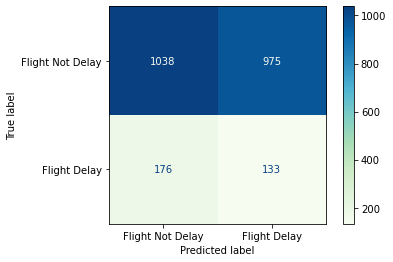

In [20]:
score(grid_lr, x_train_t, x_test_t)

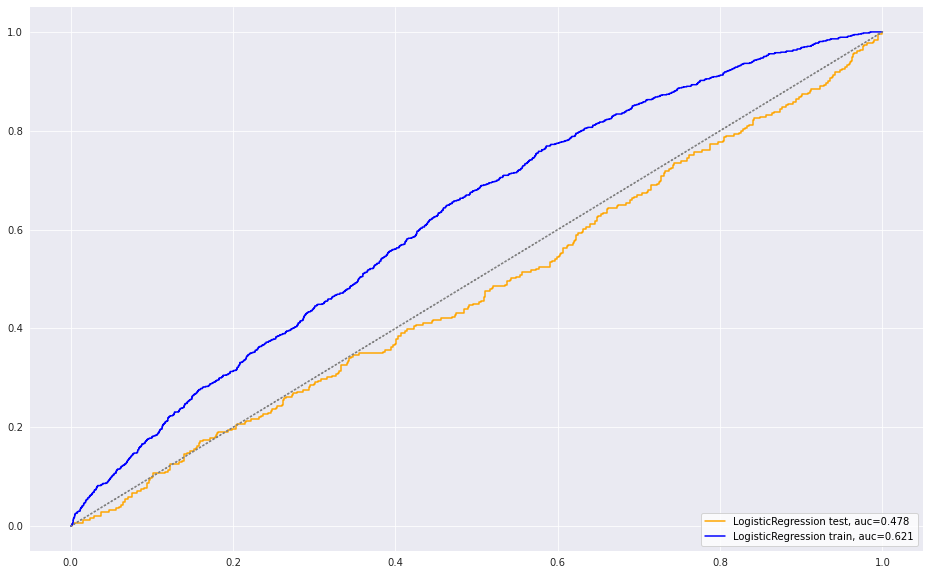

In [21]:
roc(grid_lr,"LogisticRegression", x_train_t, x_test_t)

In [22]:
importance = grid_lr.best_estimator_.named_steps['logisticregression'].coef_[0]
importance

array([ 0.0097389 , -0.11854297,  0.23121501,  0.03494366, -0.02827211,
       -0.06099629,  0.01325625,  0.00478889, -0.13085567, -0.09884237,
       -0.04351541,  0.09045065, -0.03834569, -0.02337124,  0.        ,
       -0.01454092,  0.0317786 , -0.04453103,  0.        , -0.07852189,
        0.        ,  0.        ,  0.13355782, -0.10856481, -0.33141696,
        0.09171073, -0.05560462, -0.02577124,  0.08247511, -0.07443496,
       -0.12233321, -0.02738111, -0.12541324,  0.        ,  0.20450135,
       -0.04149593,  0.10064043,  0.0719922 , -0.01882349, -0.09308145,
       -0.20153067, -0.07915239, -0.0288654 , -0.0225541 , -0.053416  ,
        0.        ,  0.13336275, -0.02414404, -0.06733388,  0.        ,
       -0.07448255,  0.16291097,  0.03912452,  0.10463518,  0.13137123,
        0.32709322,  0.15142763,  0.06479727,  0.        ,  0.        ,
       -0.04766312, -0.0526076 ,  0.        , -0.0399764 ,  0.        ,
       -0.39292581, -0.16767669,  0.        ,  0.        ,  0.  

In [23]:
feature_importance = pd.DataFrame({'features' :x_train.columns,
                                   'coefficient' : abs(importance)}).sort_values(by='coefficient', ascending = False)
feature_importance = feature_importance[:10]

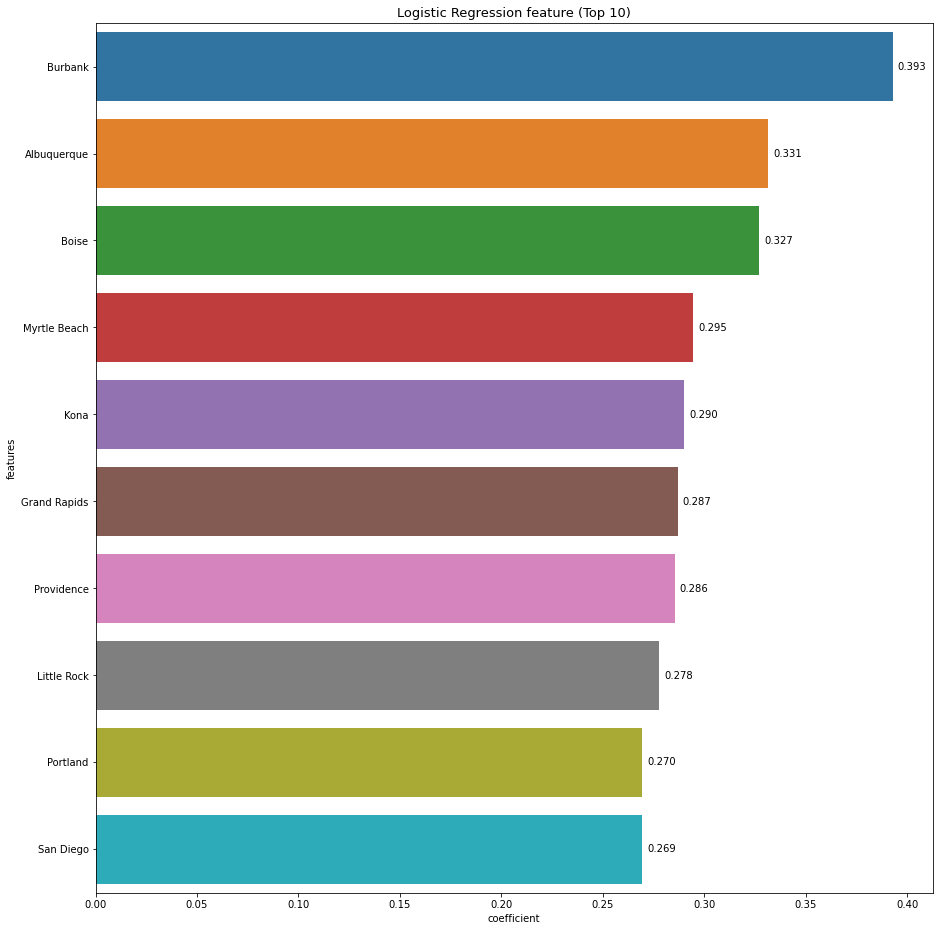

In [24]:
plt.figure(figsize = (15,16))  
ax = sns.barplot(y= feature_importance['features'], x = feature_importance['coefficient'],data = feature_importance)
plt.title('Logistic Regression feature (Top 10)', fontsize = 13)
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. 
    space = 5

    # Vertical alignment.
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = "{:.3f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

In [25]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

rf_pipe = make_pipeline(RandomForestClassifier(random_state=42))

# define grid params for random forest classifier
rf_params = {
    'randomforestclassifier__n_estimators':[20,50,100],
    'randomforestclassifier__max_depth':[5,20,50],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__max_leaf_nodes':[5,10,15],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_rf = GridSearchCV(rf_pipe, param_grid = rf_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [26]:
grid_rf.fit(x_train_t,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 20, 50],
                         'randomforestclassifier__max_leaf_nodes': [5, 10, 15],
                         'randomforestclassifier__n_estimators': [20, 50, 100]},
             scoring='roc_auc', verbose=1)

In [27]:
print("best score", grid_rf.best_score_)
print("best params", grid_rf.best_params_)

best score 0.5131584764123401
best params {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 15, 'randomforestclassifier__n_estimators': 20}


Training Score: 0.6734513668020551
Testing Score: 0.4733359377637589


              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74      2013
         1.0       0.12      0.32      0.18       309

    accuracy                           0.60      2322
   macro avg       0.49      0.48      0.46      2322
weighted avg       0.76      0.60      0.66      2322



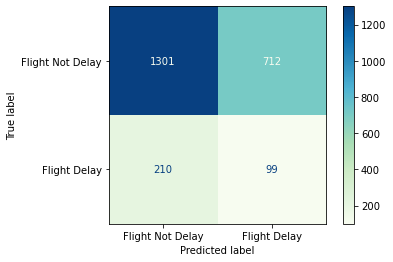

In [28]:
score(grid_rf, x_train_t, x_test_t)

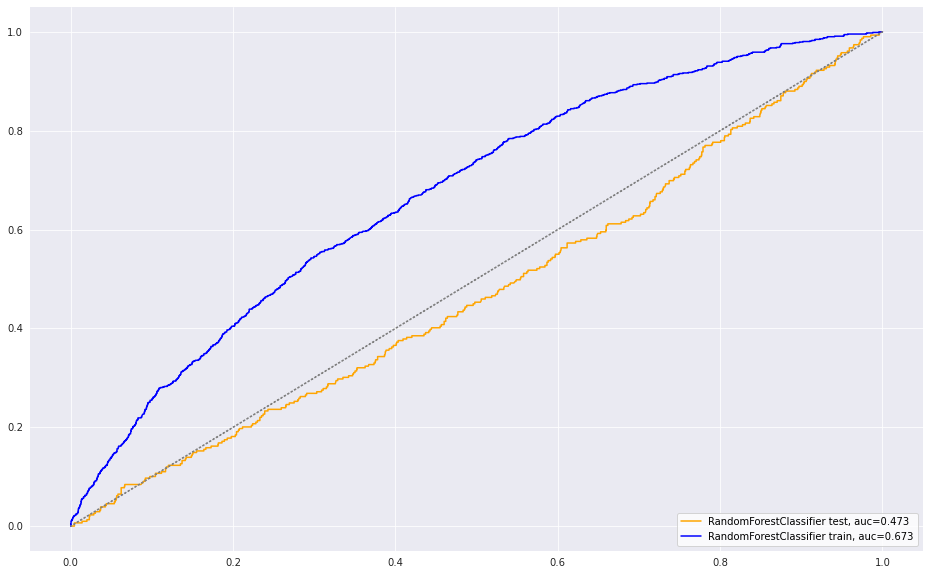

In [29]:
roc(grid_rf,"RandomForestClassifier", x_train_t, x_test_t)

In [30]:
importance = grid_rf.best_estimator_.named_steps.randomforestclassifier.feature_importances_
importance

array([0.00994808, 0.00685122, 0.02914347, 0.0469715 , 0.02789566,
       0.05882469, 0.05957294, 0.0764213 , 0.01118355, 0.04150986,
       0.05490694, 0.07530087, 0.05789624, 0.0606117 , 0.        ,
       0.05352878, 0.03546931, 0.02950872, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00121364, 0.01273977,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00115301, 0.        , 0.        , 0.        , 0.        ,
       0.00979828, 0.        , 0.        , 0.        , 0.        ,
       0.00183057, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00365759, 0.00306809, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00379033, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00235075, 0.        , 0.00299

In [31]:
feature_importance_rf = pd.DataFrame({'features' :x_train.columns,
                                   'feature_importances' : abs(importance)}).sort_values(by='feature_importances',
                                                                                         ascending = False)
feature_importance_rf = feature_importance_rf[:10]

In [32]:
feature_importance_rf['rank'] = feature_importance_rf['feature_importances'].rank(ascending = False)

feature_importance_rf

,features,feature_importances,rank
7,destairportid,0.076421,1.0
11,crsarrtime,0.075301,2.0
13,airtime,0.060612,3.0
6,originairportid,0.059573,4.0
5,flight_number_reporting_airline,0.058825,5.0
12,crselapsedtime,0.057896,6.0
10,crsdeptime,0.054907,7.0
15,distance,0.053529,8.0
3,dayofmonth,0.046972,9.0
9,destwac,0.041510,10.0


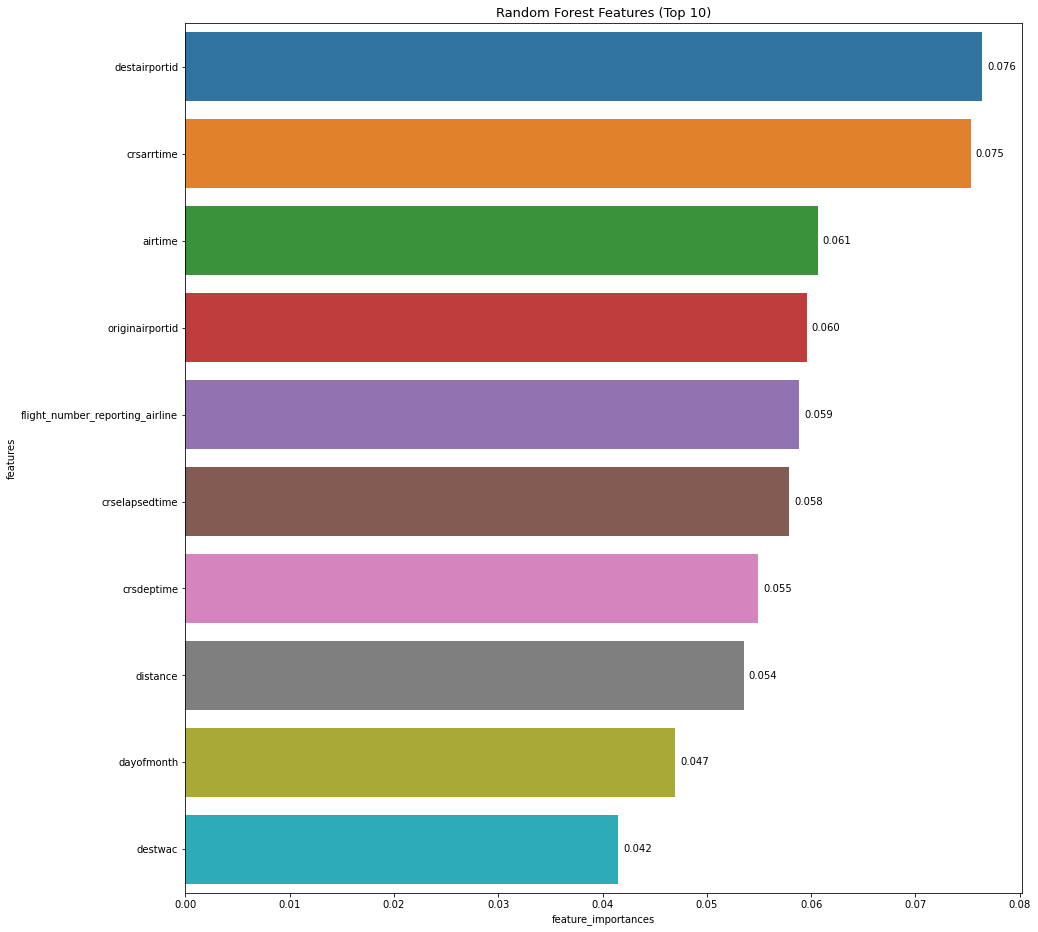

In [33]:
plt.figure(figsize = (15,16))  
ax = sns.barplot(y= feature_importance_rf['features'], x = feature_importance_rf['feature_importances'],data = feature_importance_rf)
plt.title('Random Forest Features (Top 10)', fontsize = 13)
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. 
    space = 5

    # Vertical alignment.
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = "{:.3f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()